# Experiments comparing the corpora FakeWhatsApp.Br and FakeTweet.Br
Are WhatsApp texts so unique that a corpus of WhatsApp texts is needed? Our hypothesis is that WhatsApp texts have a linguistic pattern that differs from other social networks, such as Twitter, Facebook, etc., due to the purpose of each platform.

We can mention, for example, that WhatsApp has a stronger dialogical nature, texts are generally short, there is an extensive use of emojis, media (images, audios, videos) and a profile of different use, due to data packages that allow unlimited use of the platform.

Therefore, a misinformation detection model trained with texts from other media would not perform well in WhatsApp texts. In this Notebook, we try to confirm this hypothesis, comparing it with the only known corpus up to the moment of Fake News on PT-BR from Twitter. Twitter is a platform whose texts are limited in size, possibly resembling many WhatsApp texts.

Corpus FakeTweet.Br made available on https://github.com/prc992/FakeTweet.Br

CORDEIRO, P.; Pinheiro, V.. Um Corpus de Notícias Falsas do Twitter e Verificacão Automática de Rumores em Língua Portuguesa. In: STIL 19 - Symposium in Information and Human Language Technology, 2019, Salvador. Proceedings if the STIL 19 - Symposium in Information and Human Language Technology, 2019. v. 1. p. 219-228.<br>
Homepage: http://comissoes.sbc.org.br/ce-pln/stil2019/proceedings-stil-2019-Final-Publicacao.pdf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import getTestMetrics

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from scipy.spatial import distance
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.svm import LinearSVC

from imblearn.over_sampling import SMOTE 

%matplotlib inline
sns.set(style="darkgrid")

In [2]:
#twitter concat train and test
url_twitter = 'https://raw.githubusercontent.com/prc992/FakeTweet.Br/master/FakeTweetBr.csv'
twitter = pd.read_csv(url_twitter)
url_twitter_test = 'https://raw.githubusercontent.com/prc992/FakeTweet.Br/master/FakeTweetBr-Test.csv'
twitter_test = pd.read_csv(url_twitter_test)
twitter_test['classificacao'] = [t.lower() for t in twitter_test['classificacao']]
twitter = pd.concat([twitter,twitter_test])

base = 2018
base_subset = 'viral'
filepath = 'data/' + str(base) + '/fakeWhatsApp.BR_' + str(base) + '.csv'
whatsapp = pd.read_csv(filepath)

if base_subset == 'viral':
    whatsapp = whatsapp[whatsapp['viral']==1]

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
twitter.tail()

,Unnamed: 0,id,subject,text,classificacao,date,retweets,favorites,permalink
15,691,4.210000e+17,navio msc lixo,Flagra: Navio da MSC (Mediterranean Shipping C...,fake,2014-01-09 12:03,0,0,https://twitter.com/deguchijr/status/421296141...
16,706,4.200000e+17,navio msc lixo,Coisa feia!!! Vídeo mostra navio MSC jogando l...,fake,2014-01-06 0:17,0,0,https://twitter.com/chrica2010/status/42003145...
17,779,1.120000e+18,gustave notre dame,O pintor Gustave Freipont teria previsto o inc...,true,2019-04-19 17:06,0,0,https://twitter.com/Arq_MauTavaresS/status/111...
18,797,1.120000e+18,gustave notre dame,Chegou aqui a pergunta sobre a pintura de um t...,true,2019-04-18 14:54,1,51,https://twitter.com/caduzaodamassa/status/1118...
19,815,1.120000e+18,gustave notre dame,"Essa pintura de Gustave Freipont, de 1924, se ...",fake,2019-04-17 23:26,0,0,https://twitter.com/keila_fr/status/1118702265...


In [4]:
#examples
print('WhatsApp examples')
print()

print('misinformation')
m_list = (list(whatsapp[whatsapp['misinformation']==1]['text'].sample(n=3, random_state=42)))
for m in m_list:
    print(m)    
print()

print('non-misinformation')
m_list = (list(whatsapp[whatsapp['misinformation']==0]['text'].sample(n=3, random_state=42)))
for m in m_list:
    print(m)    
print()

print('Twitter examples')
print()

print('fake')
m_list = (list(twitter[twitter['classificacao']=='fake']['text'].sample(n=3, random_state=42)))
for m in m_list:
    print(m)
print()

print('true')
m_list = (list(twitter[twitter['classificacao']=='true']['text'].sample(n=3, random_state=42)))
for m in m_list:
    print(m)

WhatsApp examples

misinformation
As provas foram entregues ao Delegado Franschini é a cúpula do PSL.
Coisa de derrubar a República...
Os militares estão ( a ala esmagadora que apoia Bolsonaro) cientes.
Rosa Weber já sabe.
Temer já sabe.
Villas Boas já sabe.
Jungleman já sabe!
A coisa tá pegando...
A quem interessar possa:
Hoje às 22:30hs na Globo News
Jair bolsonaro vai ser entrevistado por doze repórteres globais.. Vamos repassar. 
A Rede Globo não está informando como deveria para não ter que dar tanto Ibope ao Bolsonaro.

*REPASSEM*
_*TSE informa:*_ 7,2 milhões de votos anulados pelas urnas! A diferença de votos que levaria à vitória de Bolsonaro no primeiro turno foi de menos de 2 milhões .
O TSE tem obrigação de esclarecer os motivos que levaram à anulação de mais de 7,2 milhões de votos que representam 6,2% do total. A anulação só pode acontecer em voto de papel, porque permite rasuras ou ambiguidade.

Se você enviar para apenas 20 contatos em um minuto, o Brasil inteiro vai des

# Distribuitions

In [5]:
twitter['words'] = [len(s.split()) for s in twitter['text']]
twitter['chars'] = [len(s) for s in twitter['text']]

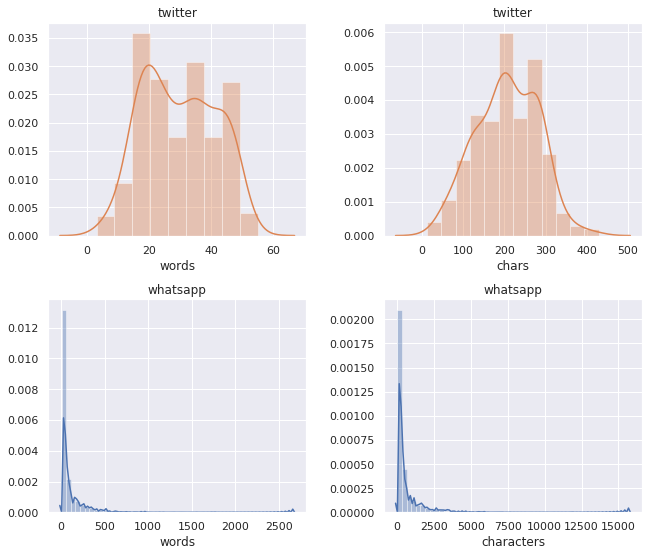

In [6]:
plt.figure(figsize=(10, 8))

plt.subplot(221)
plt.title('twitter')
sns.distplot(twitter['words'], kde = True, color = 'C1')

plt.subplot(222)
plt.title('twitter')
sns.distplot(twitter['chars'], kde = True, color = 'C1')

plt.subplot(223)
plt.title('whatsapp')
sns.distplot(whatsapp['words'], kde = True, color = 'C0')

plt.subplot(224)
plt.title('whatsapp')
sns.distplot(whatsapp['characters'], kde = True, color = 'C0')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.95, 
                    top=0.95, 
                    wspace=0.3, 
                    hspace=0.3)

plt.show()

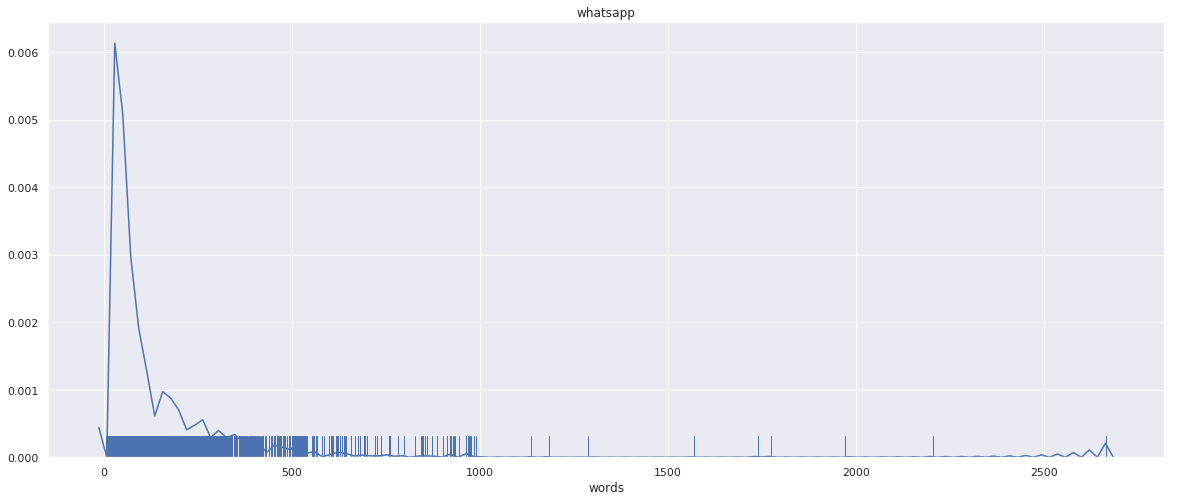

In [7]:
plt.figure(figsize=(20, 8))
plt.title('whatsapp')
sns.distplot(whatsapp[whatsapp['midia'] == 0]['words'], hist = False, kde = True, rug = True)
plt.show()

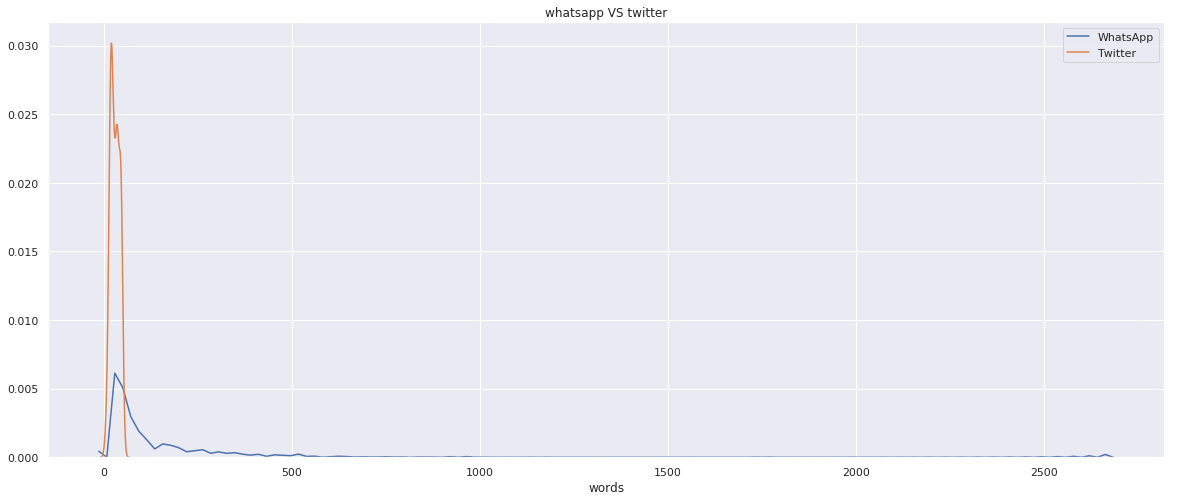

In [8]:
plt.figure(figsize=(20, 8))
plt.title('whatsapp VS twitter')
sns.distplot(whatsapp[whatsapp['midia'] == 0]['words'], hist = False, kde = True, label = 'WhatsApp')
sns.distplot(twitter['words'], hist = False, kde = True, label = 'Twitter')
plt.show()

In [9]:
whatsapp['class'] = ['fake' if s == 1 else 'non-fake' for s in whatsapp['misinformation']]

### Distribuitions by class

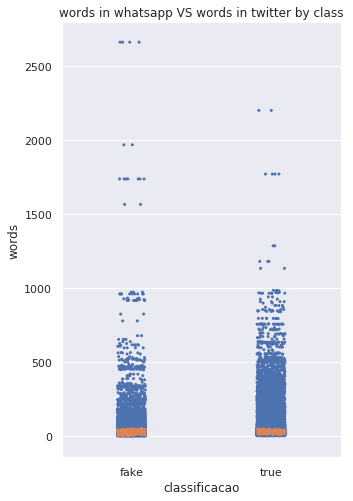

In [10]:
plt.figure(figsize=(5,8))
plt.title('words in whatsapp VS words in twitter by class')
sns.stripplot(y="words", x = 'class', size = 3, color = 'C0', data=whatsapp)
sns.stripplot(y="words", x = 'classificacao', data=twitter, size = 3, color = 'C1')
plt.show()

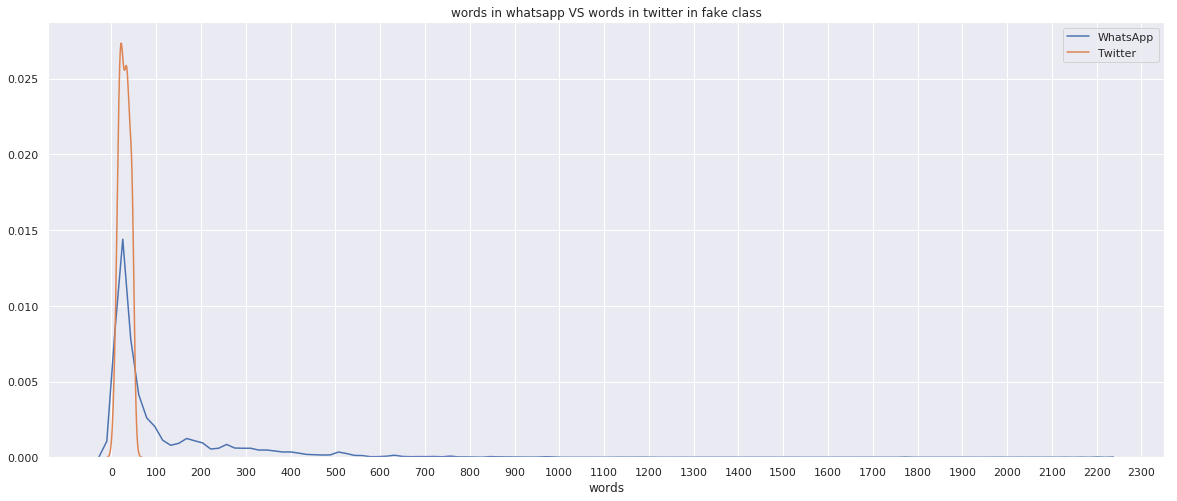

In [11]:
plt.figure(figsize=(20, 8))
plt.title('words in whatsapp VS words in twitter in fake class')
plt.xticks(np.arange(0, 2500, 100))
sns.distplot(whatsapp[(whatsapp['midia'] == 0) & (whatsapp['misinformation']==1)]['words'], hist = False, kde = True, label = 'WhatsApp')
sns.distplot(twitter[twitter['classificacao']=='fake']['words'], hist = False, kde = True, label = 'Twitter')
plt.show()

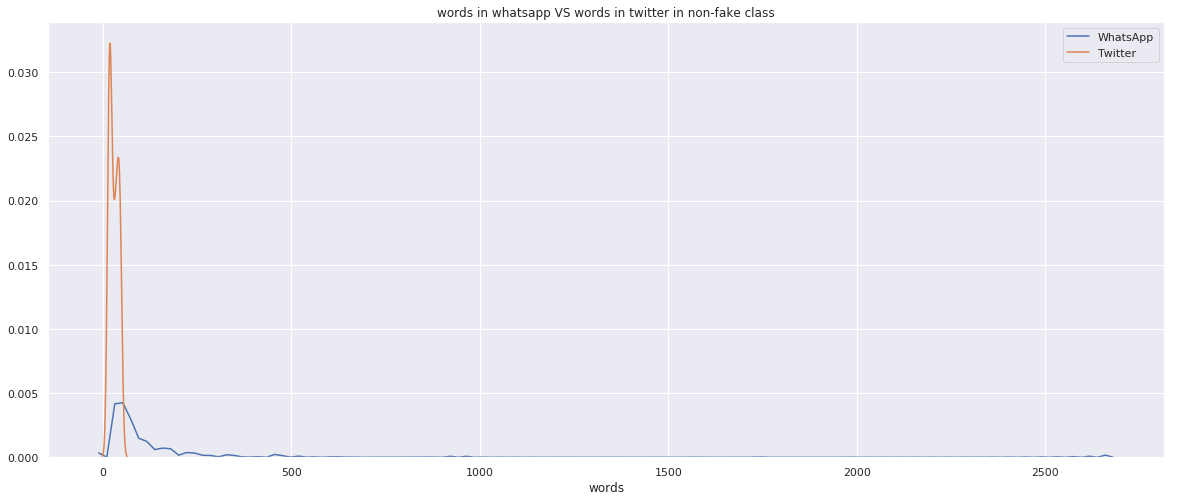

In [12]:
plt.figure(figsize=(20, 8))
plt.title('words in whatsapp VS words in twitter in non-fake class')
#plt.xticks(np.arange(0, 2500, 100))
sns.distplot(whatsapp[(whatsapp['midia'] == 0) & (whatsapp['misinformation']==0)]['words'], hist = False, kde = True, label = 'WhatsApp')
sns.distplot(twitter[twitter['classificacao']=='true']['words'], hist = False, kde = True, label = 'Twitter')
plt.show()

# Vocabulary

In [13]:
twi_set = set(' '.join(list(twitter['text'])).split())
print('Twitter')
print('Size of vocabulary:', len(twi_set))
print('Unique documents:', len(twitter['text'].unique()))
print()

wpp_set = set(' '.join(list(whatsapp['text'])).split())
print('WhatsApp')
print('Size of vocabulary:', len(wpp_set))
print('Unique documents:', len(whatsapp['text'].unique()))
print()

print('Vocab')
print('Intersection:',len(twi_set.intersection(wpp_set)))
twi_perc = len(twi_set.intersection(wpp_set))/len(twi_set)
print('Percentage in twitter: %0.2f' % twi_perc)
wpp_perc = len(twi_set.intersection(wpp_set))/len(wpp_set)
print('Percentage in whatsapp: %0.2f' % wpp_perc)
print('Diference (whatsapp - twitter):',len(wpp_set.difference(twi_set)))



Twitter
Size of vocabulary: 3279
Unique documents: 298

WhatsApp
Size of vocabulary: 56748
Unique documents: 5284

Vocab
Intersection: 1969
Percentage in twitter: 0.60
Percentage in whatsapp: 0.03
Diference (whatsapp - twitter): 54779


# Similar documents

In [14]:
#TF-IDF
vectorizer = TfidfVectorizer()
vectorizer.fit(whatsapp['text'])

wpp_tfid = vectorizer.transform(whatsapp['text'])
twitter_tfid = vectorizer.transform(twitter['text'])

#calculate cosine distance
cosine_similarities = linear_kernel(twitter_tfid, wpp_tfid)
cosine_similarities.shape

#max similaritie for each document
max_sim = cosine_similarities.max(axis = 1)
max_arg = cosine_similarities.argmax(axis = 1)
max_sim.shape

(299,)

No intersection of documents in the corpora


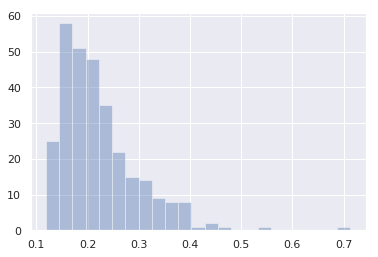

In [15]:
print('No intersection of documents in the corpora')
sns.distplot(max_sim,kde=False)
plt.show()

In [16]:
#document with max similaritie
best_match = [whatsapp.iloc[idx]['text'] for idx in max_arg] 
df_sim = pd.DataFrame({'text_twitter': twitter['text'],
         'best_match':best_match,
         'sim': max_sim})

df_sim[df_sim['sim']>0.6]

,text_twitter,best_match,sim
180,A Ponte rio niterói tem uma rachadura sinistra,"*PONTE RIO-NITERÓI, 06/10, 10h*\n\n*É BOLSONA...",0.712928


# Comparation between models of classification
An model trained with Twitter data can generalize well over WhatsApp data?
We train model with twitter data as proposed in the original paper, using the worst and the best classifiers reported (Logistic Regression and Complement Naive Bayes, respectively). 

In [17]:
#previously separated in train and test by original author
twitter = pd.read_csv(url_twitter)
twitter_test = pd.read_csv(url_twitter_test)
twitter_test['classificacao'] = [t.lower() for t in twitter_test['classificacao']]

Twitter


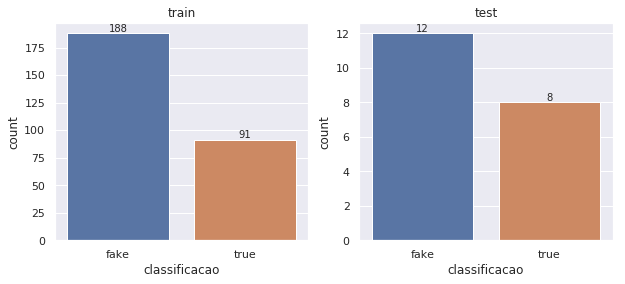

In [18]:
print('Twitter')
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.title('train')
g = sns.countplot(x='classificacao',data = twitter)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')
    
plt.subplot(122)
plt.title('test')
g = sns.countplot(x='classificacao',data = twitter_test)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

### Scenario 1: training and evaluating with Twitter data

In [19]:
#targets
y_train = [1 if s == 'fake' else 0 for s in twitter['classificacao']]
y_test = [1 if s == 'fake' else 0 for s in twitter_test['classificacao']]

#tf-idf input
vectorizer = CountVectorizer(ngram_range=(1, 2))
#vectorizer = CountVectorizer(ngram_range=(1, 1))
vectorizer = TfidfVectorizer()
vectorizer.fit(twitter['text'])

X_train = vectorizer.transform(twitter['text'])
X_test = vectorizer.transform(twitter_test['text'])

#normalization
# scaler = StandardScaler(with_mean=False)
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(279, 2411)
(20, 2411)


print('Logistic Regression unbalanced')
logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('logistic regression')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)


print('Naive-Bayes classifier unbalanced')
naiveBayes = BernoulliNB().fit(X_train, y_train)
y_pred = naiveBayes.predict(X_test)
y_prob = naiveBayes.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

scenario1_metrics = pd.DataFrame({'model':model,
                                 'accuracy':accuracy_score,
                                 'precision': precision_score,
                                 'recall': recall_score,
                                 'f1 score': f1_score,
                                 'auc score': auc_score})
scenario1_metrics

### Scenario 1:  training and evaluating with Twitter data oversampling

In [20]:
#metrics
model = []
accuracy_score = []
precision_score = []
precision_score_neg = []
recall_score = []
recall_score_neg = []
f1_score = []
f1_score_neg = []
auc_score = []

In [21]:
#oversampling with SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
X_train.shape

(376, 2411)

Logistic regression
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.71      0.83      0.77        12

    accuracy                           0.70        20
   macro avg       0.69      0.67      0.67        20
weighted avg       0.70      0.70      0.69        20

AUC:  0.7708333333333333


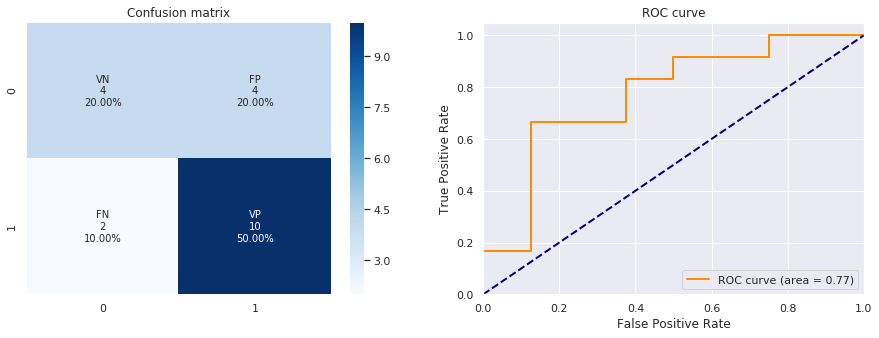

In [22]:
print('Logistic regression')
logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_test)
#y_pred = 1 - y_pred ###wtf????
y_prob = logreg.predict_proba(X_test)[:,1]
model.append('logistic regression')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Linear SVM with SGD training.
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.83      0.83      0.83        12

    accuracy                           0.80        20
   macro avg       0.79      0.79      0.79        20
weighted avg       0.80      0.80      0.80        20



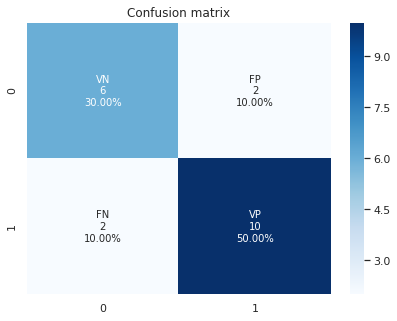

In [23]:
print('Linear SVM with SGD training.')
sgd = SGDClassifier().fit(X_train, y_train)
y_pred = sgd.predict(X_test)
model.append('sgd')

acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, full_metrics = True)

accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Naive-Bayes classifier for multivariate Bernoulli models
              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.71      1.00      0.83        12

    accuracy                           0.75        20
   macro avg       0.85      0.69      0.69        20
weighted avg       0.82      0.75      0.71        20

AUC:  0.8854166666666667


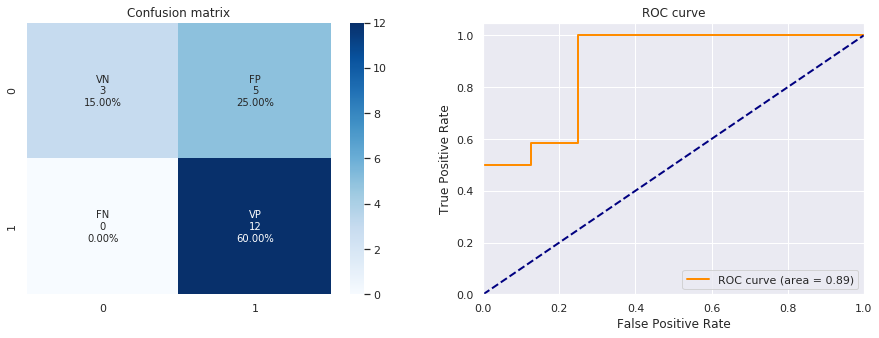

In [24]:
print('Naive-Bayes classifier for multivariate Bernoulli models')
naiveBayes = BernoulliNB().fit(X_train, y_train)
y_pred = naiveBayes.predict(X_test)
y_prob = naiveBayes.predict_proba(X_test)[:,1]

model.append('bernoulli naive-bayes')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, y_prob, full_metrics = True)

accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Random Forest
              precision    recall  f1-score   support

           0       0.50      0.12      0.20         8
           1       0.61      0.92      0.73        12

    accuracy                           0.60        20
   macro avg       0.56      0.52      0.47        20
weighted avg       0.57      0.60      0.52        20

AUC:  0.7395833333333334


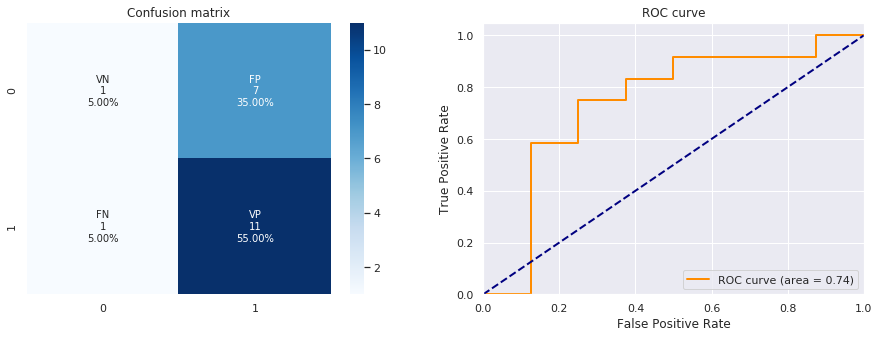

In [25]:
print('Random Forest')
rf = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
model.append('random forest')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, y_prob, full_metrics = True)

accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Linear SVM
              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.77      0.83      0.80        12

    accuracy                           0.75        20
   macro avg       0.74      0.73      0.73        20
weighted avg       0.75      0.75      0.75        20



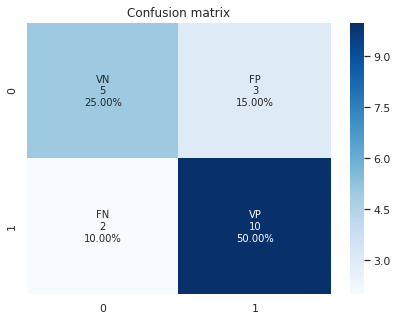

In [26]:
print('Linear SVM')
svm = LinearSVC().fit(X_train, y_train)
y_pred = svm.predict(X_test)
model.append('svm')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, full_metrics = True)

accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

In [27]:
scenario1_1_metrics = pd.DataFrame({'scenario':['1']*len(model),
                                 'model':model,
                                 'accuracy':accuracy_score,
                                 'precision 1': precision_score,
                                 'recall 1': recall_score,
                                 'f1 score 1': f1_score,
                                 'precision 0': precision_score_neg,
                                 'recall 0': recall_score_neg,                                 
                                 'f1 score 0': f1_score_neg,
                                 'auc score': auc_score})
scenario1_1_metrics

,scenario,model,accuracy,precision 1,recall 1,f1 score 1,precision 0,recall 0,f1 score 0,auc score
0,1,logistic regression,0.70,0.714286,0.833333,0.769231,0.571429,0.571429,0.571429,0.770833
1,1,sgd,0.80,0.833333,0.833333,0.833333,0.750000,0.750000,0.750000,0.000000
2,1,bernoulli naive-bayes,0.75,0.705882,1.000000,0.827586,0.545455,0.545455,0.545455,0.885417
3,1,random forest,0.60,0.611111,0.916667,0.733333,0.200000,0.200000,0.200000,0.739583
4,1,svm,0.75,0.769231,0.833333,0.800000,0.666667,0.666667,0.666667,0.000000


### Scenario 2: evaluating models trained with Twitter data in WhatsApp data
Our hypothesis is that the models will NOT be able to generalize.

In [28]:
#metrics
model = []
accuracy_score = []
precision_score = []
precision_score_neg = []
recall_score = []
recall_score_neg = []
f1_score = []
f1_score_neg = []
auc_score = []

In [29]:
#remove repeated messages
whatsapp = whatsapp.drop_duplicates(subset=['text'])
y = whatsapp['misinformation']
sentences = whatsapp['text']

#train-test split
sentences_train_wpp, sentences_test_wpp, y_train_wpp, y_test_wpp = train_test_split(sentences, y, test_size=0.20, 
                                                                    stratify = y, random_state=42)
#tf-idf input
X_test_wpp = vectorizer.transform(sentences_test_wpp)
X_test_wpp.shape

(1057, 2411)

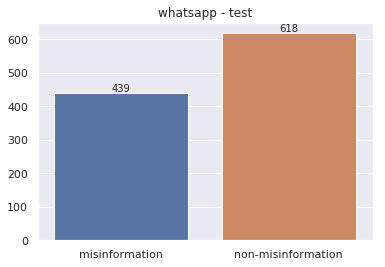

In [30]:
pos_mask = y_test_wpp == 1 
pos = y_test_wpp[pos_mask]
neg_mask = y_test_wpp == 0 
neg = y_test_wpp[neg_mask]
#print('fakes: ', pos.shape)
#print('non-fakes: ', neg.shape)
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']

plt.title('whatsapp - test')
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

Logistic Regression trained with twitter and evaluated in WhatsApp
              precision    recall  f1-score   support

           0       0.64      0.13      0.22       618
           1       0.42      0.90      0.57       439

    accuracy                           0.45      1057
   macro avg       0.53      0.51      0.40      1057
weighted avg       0.55      0.45      0.37      1057

AUC:  0.5490412897803923


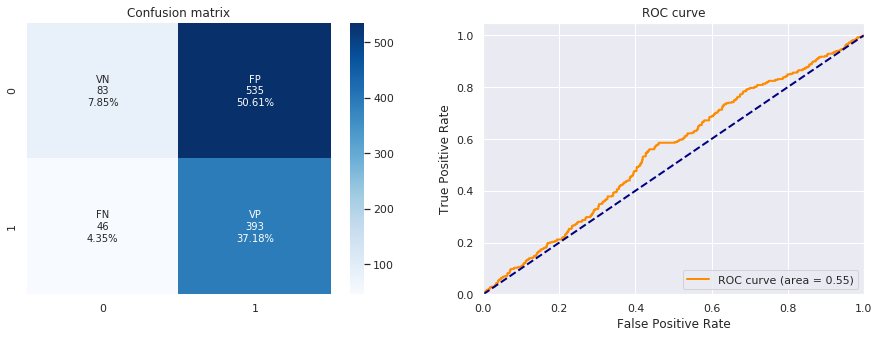

In [31]:
print('Logistic Regression trained with twitter and evaluated in WhatsApp')
y_pred = logreg.predict(X_test_wpp)
y_prob = logreg.predict_proba(X_test_wpp)[:,1]
model.append('logistic regression')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test_wpp, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

SGD trained with twitter and evaluated in WhatsApp
              precision    recall  f1-score   support

           0       0.62      0.18      0.27       618
           1       0.42      0.85      0.56       439

    accuracy                           0.46      1057
   macro avg       0.52      0.51      0.42      1057
weighted avg       0.54      0.46      0.40      1057



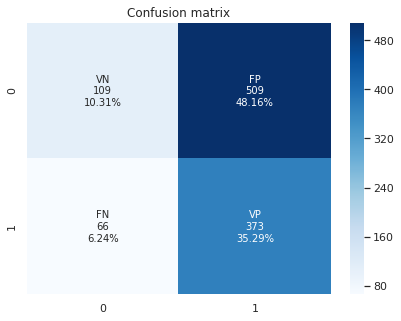

In [32]:
#svm
print('SGD trained with twitter and evaluated in WhatsApp')
y_pred = sgd.predict(X_test_wpp)
model.append('sgd')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test_wpp, y_pred, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Bernoulli Naive-Bayes trained with twitter and evaluated in WhatsApp
              precision    recall  f1-score   support

           0       0.50      0.03      0.05       618
           1       0.41      0.96      0.58       439

    accuracy                           0.42      1057
   macro avg       0.46      0.49      0.31      1057
weighted avg       0.46      0.42      0.27      1057

AUC:  0.579905419053306


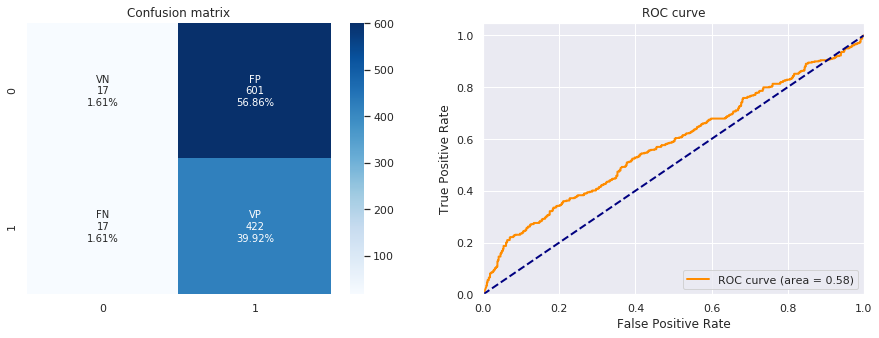

In [33]:
#svm
print('Bernoulli Naive-Bayes trained with twitter and evaluated in WhatsApp')
y_pred = naiveBayes.predict(X_test_wpp)
y_prob = naiveBayes.predict_proba(X_test_wpp)[:,1]
model.append('bernoulli naive-bayes')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test_wpp, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Random Forest trained with twitter and evaluated in WhatsApp
              precision    recall  f1-score   support

           0       0.45      0.04      0.08       618
           1       0.41      0.92      0.57       439

    accuracy                           0.41      1057
   macro avg       0.43      0.48      0.32      1057
weighted avg       0.43      0.41      0.28      1057

AUC:  0.3834453855850676


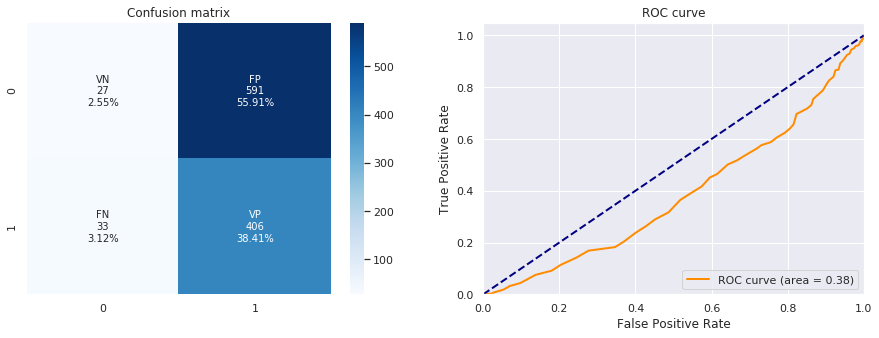

In [34]:
print('Random Forest trained with twitter and evaluated in WhatsApp')
y_pred = rf.predict(X_test_wpp)
y_prob = rf.predict_proba(X_test_wpp)[:,1]
model.append('random forest')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test_wpp, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Linear SVM trained with twitter and evaluated in WhatsApp
              precision    recall  f1-score   support

           0       0.64      0.14      0.24       618
           1       0.42      0.89      0.57       439

    accuracy                           0.45      1057
   macro avg       0.53      0.52      0.40      1057
weighted avg       0.55      0.45      0.38      1057



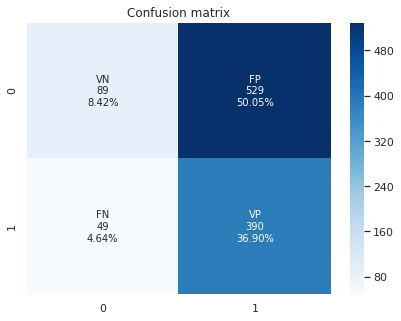

In [35]:
print('Linear SVM trained with twitter and evaluated in WhatsApp')
y_pred = svm.predict(X_test_wpp)
model.append('svm')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test_wpp, y_pred, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

In [36]:
scenario2_metrics = pd.DataFrame({'scenario':['2']*len(model),
                                 'model':model,
                                 'accuracy':accuracy_score,
                                 'precision 1': precision_score,
                                 'recall 1': recall_score,
                                 'f1 score 1': f1_score,
                                 'precision 0': precision_score_neg,
                                 'recall 0': recall_score_neg,                                 
                                 'f1 score 0': f1_score_neg,
                                 'auc score': auc_score})
scenario2_metrics

,scenario,model,accuracy,precision 1,recall 1,f1 score 1,precision 0,recall 0,f1 score 0,auc score
0,2,logistic regression,0.450331,0.423491,0.895216,0.574982,0.222222,0.222222,0.222222,0.549041
1,2,sgd,0.456008,0.422902,0.849658,0.564724,0.274905,0.274905,0.274905,0.000000
2,2,bernoulli naive-bayes,0.415326,0.412512,0.961276,0.577291,0.052147,0.052147,0.052147,0.579905
3,2,random forest,0.409650,0.407222,0.924829,0.565460,0.079646,0.079646,0.079646,0.383445
4,2,svm,0.453169,0.424374,0.888383,0.574374,0.235450,0.235450,0.235450,0.000000


### Scenario 3: training and evaluating models with WhatsApp data

In [37]:
#metrics
model = []
accuracy_score = []
precision_score = []
precision_score_neg = []
recall_score = []
recall_score_neg = []
f1_score = []
f1_score_neg = []
auc_score = []

In [38]:
X_train_wpp = vectorizer.fit_transform(sentences_train_wpp)
X_test_wpp = vectorizer.transform(sentences_test_wpp)
print(X_train_wpp.shape)
print(X_test_wpp.shape)
#oversampling
X_train_wpp, y_train_wpp = sm.fit_resample(X_train_wpp, y_train_wpp)
print(X_train_wpp.shape)

(4227, 24442)
(1057, 24442)
(4946, 24442)


In [39]:
X_test = vectorizer.transform(twitter_test['text'])
X_test.shape

(20, 24442)

Logistic Regression trained and tested with WhatsApp data
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       618
           1       0.73      0.74      0.73       439

    accuracy                           0.78      1057
   macro avg       0.77      0.77      0.77      1057
weighted avg       0.78      0.78      0.78      1057

AUC:  0.8567684720348542


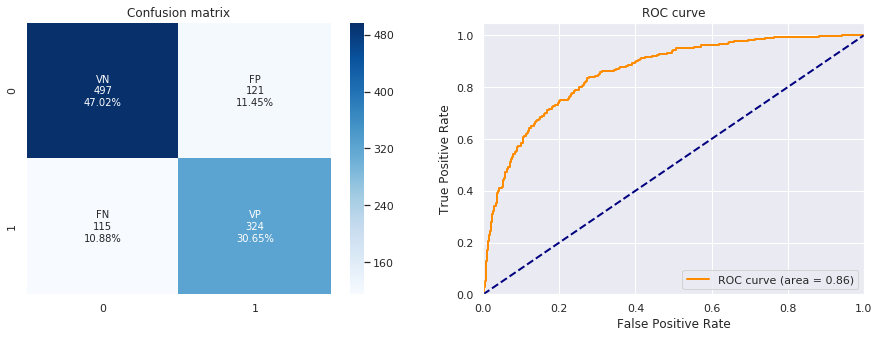

In [40]:
print('Logistic Regression trained and tested with WhatsApp data')
logreg = LogisticRegression().fit(X_train_wpp, y_train_wpp)
y_pred = logreg.predict(X_test_wpp)
y_prob = logreg.predict_proba(X_test_wpp)[:,1]
model.append('logistic regression')

acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test_wpp, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

SGD trained and tested with WhatsApp data
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       618
           1       0.74      0.73      0.73       439

    accuracy                           0.78      1057
   macro avg       0.77      0.77      0.77      1057
weighted avg       0.78      0.78      0.78      1057



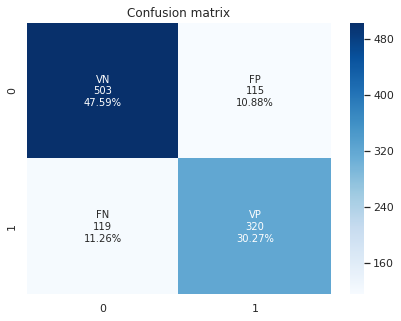

In [41]:
print('SGD trained and tested with WhatsApp data')
sgd = SGDClassifier().fit(X_train_wpp, y_train_wpp)
y_pred = sgd.predict(X_test_wpp)
model.append('sgd')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test_wpp, y_pred, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Bernoulli Naive-Bayes trained and tested with WhatsApp data
              precision    recall  f1-score   support

           0       0.66      0.96      0.78       618
           1       0.85      0.32      0.46       439

    accuracy                           0.69      1057
   macro avg       0.76      0.64      0.62      1057
weighted avg       0.74      0.69      0.65      1057

AUC:  0.7659895614481278


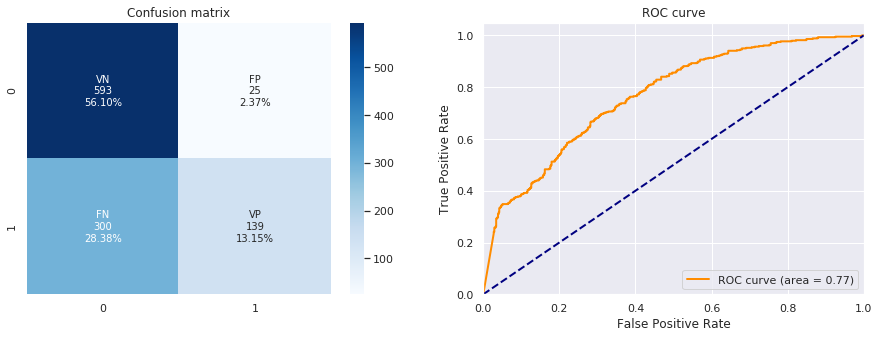

In [42]:
print('Bernoulli Naive-Bayes trained and tested with WhatsApp data')
naiveBayes = BernoulliNB().fit(X_train_wpp, y_train_wpp)
y_pred = naiveBayes.predict(X_test_wpp)
y_prob = naiveBayes.predict_proba(X_test_wpp)[:,1]
model.append('bernoulli naive-bayes')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test_wpp, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Random Forest trained and tested with WhatsApp data
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       618
           1       0.82      0.62      0.70       439

    accuracy                           0.78      1057
   macro avg       0.79      0.76      0.77      1057
weighted avg       0.79      0.78      0.78      1057

AUC:  0.8566228778261863


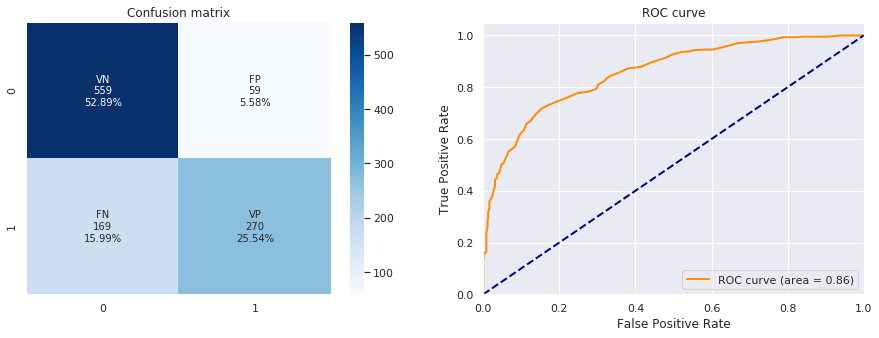

In [43]:
print('Random Forest trained and tested with WhatsApp data')
rf = RandomForestClassifier().fit(X_train_wpp, y_train_wpp)
y_pred = rf.predict(X_test_wpp)
y_prob = rf.predict_proba(X_test_wpp)[:,1]
model.append('random forest')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test_wpp, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Linear SVM  trained and tested with WhatsApp data
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       618
           1       0.75      0.73      0.74       439

    accuracy                           0.79      1057
   macro avg       0.78      0.78      0.78      1057
weighted avg       0.79      0.79      0.79      1057



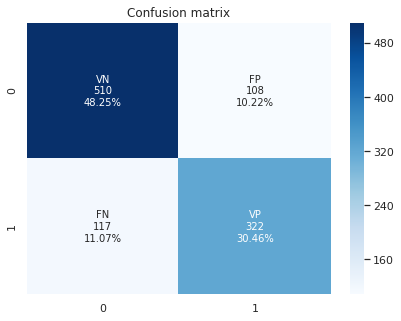

In [44]:
print('Linear SVM  trained and tested with WhatsApp data')
svm = LinearSVC().fit(X_train_wpp, y_train_wpp)
y_pred = svm.predict(X_test_wpp)
model.append('svm')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test_wpp, y_pred, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

In [45]:
scenario3_metrics = pd.DataFrame({'scenario':['3']*len(model),
                                 'model':model,
                                 'accuracy':accuracy_score,
                                 'precision 1': precision_score,
                                 'recall 1': recall_score,
                                 'f1 score 1': f1_score,
                                 'precision 0': precision_score_neg,
                                 'recall 0': recall_score_neg,                                 
                                 'f1 score 0': f1_score_neg,
                                 'auc score': auc_score})
scenario3_metrics

,scenario,model,accuracy,precision 1,recall 1,f1 score 1,precision 0,recall 0,f1 score 0,auc score
0,3,logistic regression,0.776727,0.728090,0.738041,0.733032,0.808130,0.808130,0.808130,0.856768
1,3,sgd,0.778619,0.735632,0.728929,0.732265,0.811290,0.811290,0.811290,0.000000
2,3,bernoulli naive-bayes,0.692526,0.847561,0.316629,0.461028,0.784911,0.784911,0.784911,0.765990
3,3,random forest,0.784295,0.820669,0.615034,0.703125,0.830609,0.830609,0.830609,0.856623
4,3,svm,0.787133,0.748837,0.733485,0.741082,0.819277,0.819277,0.819277,0.000000


### Scenario 4: evaluating models trained with WhatsApp data in Twitter data


In [46]:
#metrics
model = []
accuracy_score = []
precision_score = []
precision_score_neg = []
recall_score = []
recall_score_neg = []
f1_score = []
f1_score_neg = []
auc_score = []

Logistic Regression trained with WhatsApp and evaluated in Twitter
              precision    recall  f1-score   support

           0       0.47      0.88      0.61         8
           1       0.80      0.33      0.47        12

    accuracy                           0.55        20
   macro avg       0.63      0.60      0.54        20
weighted avg       0.67      0.55      0.53        20

AUC:  0.5729166666666667


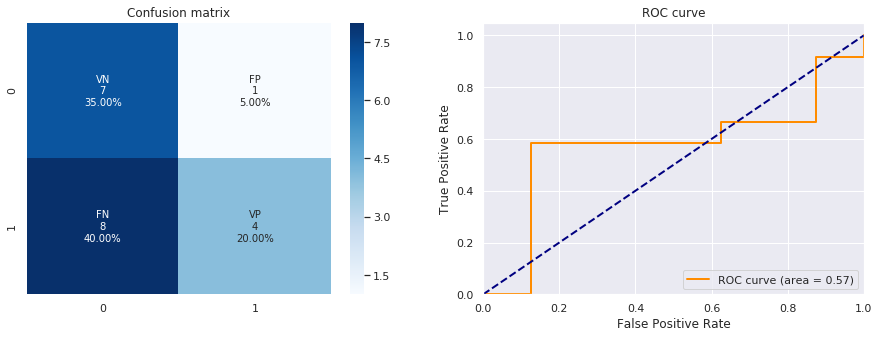

In [47]:
print('Logistic Regression trained with WhatsApp and evaluated in Twitter')
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]
model.append('logistic regression')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

SGD trained with WhatsApp and evaluated in Twitter
              precision    recall  f1-score   support

           0       0.40      0.75      0.52         8
           1       0.60      0.25      0.35        12

    accuracy                           0.45        20
   macro avg       0.50      0.50      0.44        20
weighted avg       0.52      0.45      0.42        20



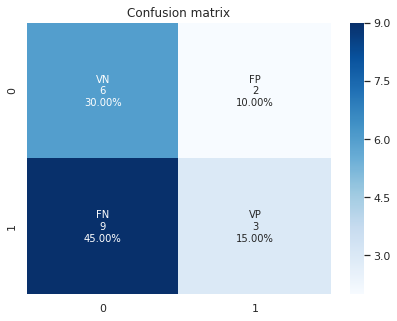

In [48]:
#svm
print('SGD trained with WhatsApp and evaluated in Twitter')
y_pred = sgd.predict(X_test)
model.append('sgd')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Bernoulli Naive-Bayes trained with twitter and evaluated in WhatsApp
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         8
           1       0.00      0.00      0.00        12

    accuracy                           0.40        20
   macro avg       0.20      0.50      0.29        20
weighted avg       0.16      0.40      0.23        20

AUC:  0.45833333333333337


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cabral/anaconda3/lib/pyth

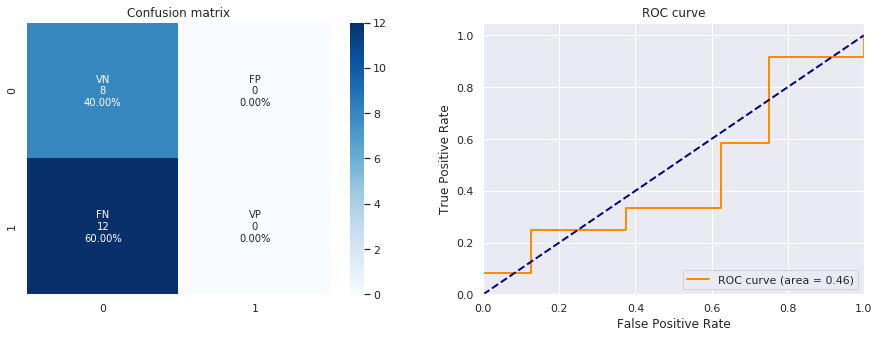

In [49]:
#svm
print('Bernoulli Naive-Bayes trained with twitter and evaluated in WhatsApp')
y_pred = naiveBayes.predict(X_test)
y_prob = naiveBayes.predict_proba(X_test)[:,1]
model.append('bernoulli naive-bayes')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Random Forest trained with twitter and evaluated in WhatsApp
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         8
           1       0.00      0.00      0.00        12

    accuracy                           0.40        20
   macro avg       0.20      0.50      0.29        20
weighted avg       0.16      0.40      0.23        20



/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cabral/anaconda3/lib/pyth

AUC:  0.43229166666666663


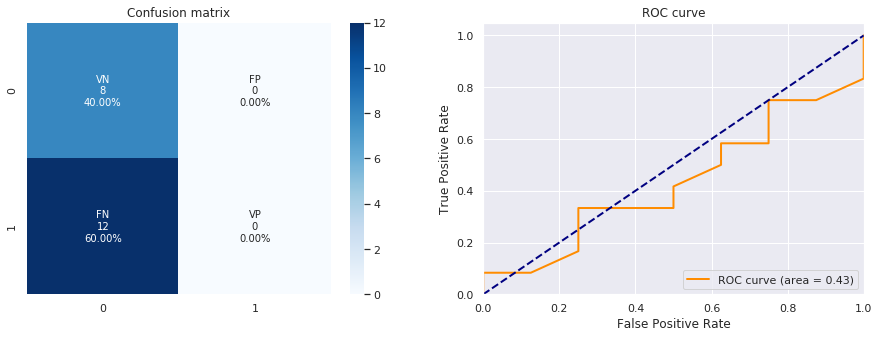

In [50]:
print('Random Forest trained with twitter and evaluated in WhatsApp')
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
model.append('random forest')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Linear SVM trained with twitter and evaluated in WhatsApp
              precision    recall  f1-score   support

           0       0.40      0.75      0.52         8
           1       0.60      0.25      0.35        12

    accuracy                           0.45        20
   macro avg       0.50      0.50      0.44        20
weighted avg       0.52      0.45      0.42        20



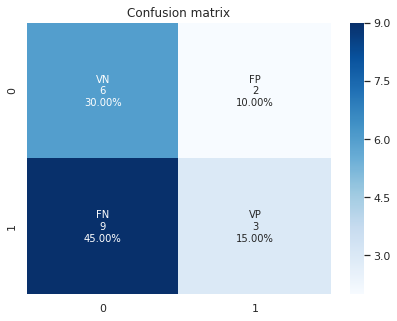

In [51]:
print('Linear SVM trained with twitter and evaluated in WhatsApp')
y_pred = svm.predict(X_test)
model.append('svm')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

In [52]:
scenario4_metrics = pd.DataFrame({'scenario':['4']*len(model),
                                 'model':model,
                                 'accuracy':accuracy_score,
                                 'precision 1': precision_score,
                                 'recall 1': recall_score,
                                 'f1 score 1': f1_score,
                                 'precision 0': precision_score_neg,
                                 'recall 0': recall_score_neg,                                 
                                 'f1 score 0': f1_score_neg,
                                 'auc score': auc_score})
scenario4_metrics

,scenario,model,accuracy,precision 1,recall 1,f1 score 1,precision 0,recall 0,f1 score 0,auc score
0,4,logistic regression,0.55,0.8,0.333333,0.470588,0.608696,0.608696,0.608696,0.572917
1,4,sgd,0.45,0.6,0.250000,0.352941,0.521739,0.521739,0.521739,0.000000
2,4,bernoulli naive-bayes,0.40,0.0,0.000000,0.000000,0.571429,0.571429,0.571429,0.458333
3,4,random forest,0.40,0.0,0.000000,0.000000,0.571429,0.571429,0.571429,0.432292
4,4,svm,0.45,0.6,0.250000,0.352941,0.521739,0.521739,0.521739,0.000000


# Comparation between scenarios

In [57]:
df_metrics = pd.concat([scenario1_1_metrics, scenario2_metrics, scenario3_metrics, scenario4_metrics])

In [58]:
filepath = 'results/' + str(base) + '/' + base_subset + '/corpora/compare_corpora.csv'
filepath

'results/2018/viral/corpora/compare_corpora.csv'

In [59]:
df_metrics.to_csv(filepath, index = False)

In [60]:
df_metrics = pd.read_csv(filepath)
df_metrics['scenario'] = df_metrics['scenario'].astype('str')
df_metrics['f1 avg'] = (df_metrics['f1 score 1'] + df_metrics['f1 score 0'])/2
#df_metrics = df_metrics.reset_index()
#df_metrics = df_metrics.drop(columns = ['index'])
#df_metrics = df_metrics.sort_values(by='f1 score',ascending=False)
df_metrics.style.background_gradient(cmap='Blues')

,scenario,model,accuracy,precision 1,recall 1,f1 score 1,precision 0,recall 0,f1 score 0,auc score,f1 avg
0,1,logistic regression,0.700000,0.714286,0.833333,0.769231,0.571429,0.571429,0.571429,0.770833,0.670330
1,1,sgd,0.800000,0.833333,0.833333,0.833333,0.750000,0.750000,0.750000,0.000000,0.791667
2,1,bernoulli naive-bayes,0.750000,0.705882,1.000000,0.827586,0.545455,0.545455,0.545455,0.885417,0.686520
3,1,random forest,0.600000,0.611111,0.916667,0.733333,0.200000,0.200000,0.200000,0.739583,0.466667
4,1,svm,0.750000,0.769231,0.833333,0.800000,0.666667,0.666667,0.666667,0.000000,0.733333
5,2,logistic regression,0.450331,0.423491,0.895216,0.574982,0.222222,0.222222,0.222222,0.549041,0.398602
6,2,sgd,0.456008,0.422902,0.849658,0.564724,0.274905,0.274905,0.274905,0.000000,0.419815
7,2,bernoulli naive-bayes,0.415326,0.412512,0.961276,0.577291,0.052147,0.052147,0.052147,0.579905,0.314719
8,2,random forest,0.409650,0.407222,0.924829,0.565460,0.079646,0.079646,0.079646,0.383445,0.322553
9,2,svm,0.453169,0.424374,0.888383,0.574374,0.235450,0.235450,0.235450,0.000000,0.404912


# Conclusion
Under the same circunstances, the models perform better over WhatsApp data when trained with WhatsApp data, justifying the necessity of this corpus, since the tasks are very different.
### NEXT STEPS
Train and evaluate better models with WhatsApp Data